# 1. Introduction

We are provided with historical sales data for 45 Walmart stores located in different regions. 
Each store contains a number of departments, and our task is to predict the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. 
Part of the challenge presented by this task is to model the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data

**Submitted By : _Shriya Jain_**

# 2. Data Prepration

## 2.1 Import libraries

In [1]:

import pandas_profiling 
import numpy as np
import pandas as pd
import seaborn as sns
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.externals import joblib
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 2.2 Load Data

In [2]:
train = pd.read_csv('data/train.csv')
feature = pd.read_csv('data/features.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')

Excel file to store intermediate outputs

In [3]:
writer=pd.ExcelWriter('Walmart Store Sales Prediction output.xlsx', engine='xlsxwriter')

    Merging the DataSet 
      -(train+Store+Feature) 
      -(test+Store+Feature)

In [4]:
train_bt = pd.merge(train,stores) 
train = pd.merge(train_bt,feature)

test_bt = pd.merge(test,stores)
test= pd.merge(test_bt,feature)

In [5]:
train.head(2)          

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [6]:
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [7]:
"Train"
train.info()
"*"*50
"Test"
test.info()

'Train'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


'**************************************************'

'Test'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Store           115064 non-null int64
Dept            115064 non-null int64
Date            115064 non-null object
IsHoliday       115064 non-null bool
Type            115064 non-null object
Size            115064 non-null int64
Temperature     115064 non-null float64
Fuel_Price      115064 non-null float64
MarkDown1       114915 non-null float64
MarkDown2       86437 non-null float64
MarkDown3       105235 non-null float64
MarkDown4       102176 non-null float64
MarkDown5       115064 non-null float64
CPI             76902 non-null float64
Unemployment    76902 non-null float64
dtypes: bool(1), float64(9), int64(3), object(2)
memory usage: 13.3+ MB


### 2.3 Idenitifying String and Numeric data

#### 2.3.1 Training Data

In [8]:
# Train Numerical Data
numeric_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
train_num=train[numeric_var_train]

# Train Categorical Data
cat_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['object']]
train_cat=train[cat_var_train]
"Numeric Train : " , numeric_var_train
"Cateogrical Train : " , cat_var_train

('Numeric Train : ',
 ['CPI',
  'Temperature',
  'Unemployment',
  'Weekly_Sales',
  'MarkDown4',
  'Dept',
  'Fuel_Price',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown5',
  'Store',
  'Size'])

('Cateogrical Train : ', ['Date', 'Type'])

#### 2.3.2 Testing Data

In [9]:
# Train Numerical Data
numeric_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
test_num=test[numeric_var_test]

# Train Categorical Data
cat_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['object']]
test_cat=test[cat_var_test]
"Numeric Test : ",numeric_var_test
"Categorical Test : ",cat_var_test

('Numeric Test : ',
 ['CPI',
  'Temperature',
  'Unemployment',
  'MarkDown4',
  'Dept',
  'Fuel_Price',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown5',
  'Store',
  'Size'])

('Categorical Test : ', ['Date', 'Type'])

### 2.4 Data Summary

In [10]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])


#### 2.4.1 Training Data

In [11]:
num_summary=train_num.apply(lambda x: var_summary(x)).T
num_summary.to_excel(writer,'Numeric_variable Summary',index=True)
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CPI,421570.0,0.0,7.217360e+07,171.201947,182.31878,39.159276,1.533449e+03,126.064,126.111903,126.496258,128.823806,132.022667,182.31878,212.416993,219.444244,221.941558,225.473509,227.232807
Temperature,421570.0,0.0,2.533217e+07,60.090059,62.09000,18.447931,3.403262e+02,-2.060,18.300000,27.310000,33.980000,46.680000,62.09000,74.280000,83.580000,87.270000,92.810000,100.140000
Unemployment,421570.0,0.0,3.355819e+06,7.960289,7.86600,1.863296,3.471872e+00,3.879,4.156000,5.326000,5.965000,6.891000,7.86600,8.572000,9.816000,12.187000,14.180000,14.313000
Weekly_Sales,421570.0,0.0,6.737219e+09,15981.258123,7612.03000,22711.183519,5.157979e+08,-4988.940,5.000000,59.974500,291.097000,2079.650000,7612.03000,20205.852500,42845.673000,61201.951000,106479.586000,693099.360000
MarkDown4,134967.0,286603.0,4.566161e+08,3383.168256,1481.31000,6292.384031,3.959410e+07,0.220,3.970000,28.760000,108.710000,504.220000,1481.31000,3595.040000,7871.420000,12645.960000,35785.260000,67474.850000
Dept,421570.0,0.0,1.865882e+07,44.260317,37.00000,30.492054,9.297654e+02,1.000,1.000000,4.000000,7.000000,18.000000,37.00000,74.000000,92.000000,95.000000,98.000000,99.000000
Fuel_Price,421570.0,0.0,1.416908e+06,3.361027,3.45200,0.458515,2.102356e-01,2.472,2.565000,2.653000,2.720000,2.933000,3.45200,3.738000,3.917000,4.029000,4.202000,4.468000
MarkDown1,150681.0,270889.0,1.091898e+09,7246.420196,5347.45000,8291.221345,6.874435e+07,0.270,17.760000,149.190000,375.200000,2240.270000,5347.45000,9210.900000,15282.470000,21801.350000,41524.030000,88646.760000
MarkDown2,111248.0,310322.0,3.709708e+08,3334.628621,192.00000,9475.357325,8.978240e+07,-265.760,-0.990000,1.950000,6.980000,41.600000,192.00000,1926.940000,8549.740000,16497.470000,50366.600000,104519.540000
MarkDown3,137091.0,284479.0,1.973317e+08,1439.421384,24.60000,9623.078290,9.260364e+07,-29.100,0.060000,0.650000,1.650000,5.080000,24.60000,103.990000,400.090000,1059.900000,63143.290000,141630.610000


In [12]:
cat_summary=train_cat.apply(lambda x: cat_summary(x))
cat_summary

,Date,Type
N,421570,421570
NMISS,0,0
ColumnsNames,2011-12-23 3027 2011-11-25 3021 2011-12-...,A 215478 B 163495 C 42597 Name: Type...


#### 2.4.2 Testing Data

In [13]:
num_summary=test_num.apply(lambda x: var_summary(x)).T
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CPI,76902.0,38162.0,1.360868e+07,176.961347,192.304445,41.239967,1.700735e+03,131.236226,131.279355,131.4784,132.030871,138.402033,192.304445,223.244532,225.898059,227.784753,228.729864,228.976456
Temperature,115064.0,0.0,6.206760e+06,53.941804,54.470000,18.724153,3.505939e+02,-7.290000,11.440000,23.9800,29.970000,39.820000,54.470000,67.350000,79.480000,83.820000,92.140000,101.950000
Unemployment,76902.0,38162.0,5.282193e+05,6.868733,6.806000,1.583427,2.507242e+00,3.684000,3.879000,3.9320,5.049000,5.771000,6.806000,8.036000,8.934000,9.910000,10.199000,10.199000
MarkDown4,102176.0,12888.0,3.429250e+08,3356.219071,840.940000,7570.501545,5.731249e+07,0.220000,2.610000,16.9600,37.360000,155.460000,840.940000,3096.920000,7674.410000,14191.010000,44739.280000,65344.640000
Dept,115064.0,0.0,5.101883e+06,44.339524,37.000000,30.656410,9.398155e+02,1.000000,1.000000,4.0000,7.000000,18.000000,37.000000,74.000000,92.000000,95.000000,98.000000,99.000000
Fuel_Price,115064.0,0.0,4.121070e+05,3.581546,3.606000,0.239442,5.733244e-02,2.872000,2.957000,3.1610,3.227000,3.431000,3.606000,3.766000,3.866000,3.951000,4.079000,4.125000
MarkDown1,114915.0,149.0,8.836063e+08,7689.216439,4842.290000,10698.760716,1.144635e+08,-2781.450000,20.840000,189.4900,457.660000,1966.460000,4842.290000,9439.140000,15325.040000,23140.880000,65757.570000,103184.980000
MarkDown2,86437.0,28627.0,3.227602e+08,3734.051729,742.590000,8323.495014,6.928057e+07,-35.740000,0.020000,6.1400,25.770000,180.350000,742.590000,2735.670000,9277.290000,22671.670000,42920.210000,71074.170000
MarkDown3,105235.0,9829.0,2.528890e+08,2403.088666,78.260000,13767.939313,1.895562e+08,-179.260000,0.150000,1.1800,3.100000,15.100000,78.260000,272.580000,698.930000,2361.570000,86476.660000,149483.310000
MarkDown5,115064.0,0.0,4.513594e+08,3922.681189,2390.430000,19445.150745,3.781139e+08,-185.170000,269.300000,540.8900,770.883000,1309.300000,2390.430000,4227.270000,6966.340000,9316.710000,18599.300000,771448.100000


In [14]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=test_cat.apply(lambda x: cat_summary(x))
cat_summary

,Date,Type
N,115064,115064
NMISS,0,0
ColumnsNames,2012-12-21 3002 2012-12-07 2989 2012-12-...,"A 58713 B 44500 C 11851 Name: Type, d..."


### 2.5 Profile Report

#### 2.5.1 Training Data

In [15]:
pandas_profiling.ProfileReport(train)

Number of variables,16
Number of observations,421570
Total Missing (%),0.0%
Total size in memory,51.9 MiB
Average record size in memory,129.0 B
Numeric,13
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


#### 2.5.2 Testing Data

In [16]:
pandas_profiling.ProfileReport(test)

Number of variables,15
Number of observations,115064
Total Missing (%),0.0%
Total size in memory,13.3 MiB
Average record size in memory,121.0 B
Numeric,12
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


- Markdown5 is skewed

### 2.6 Correlation

#### 2.6.1 Training Data

In [20]:
%matplotlib inline

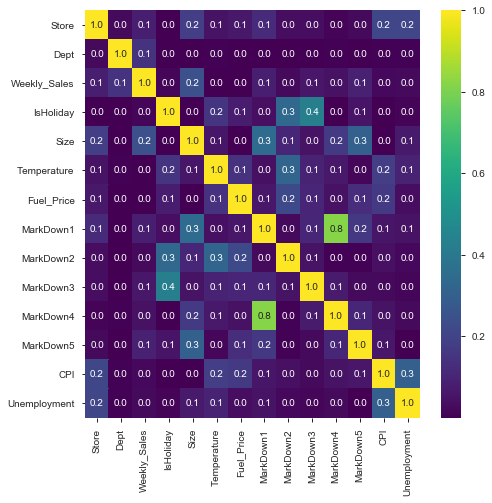

In [22]:
train_corr=pd.DataFrame(train.corr())
train_corr.to_excel(writer,'Train_Data Corr',index=True)
fig, ax = plt.subplots(figsize=(7.5,7.5))  
sns.heatmap(train_corr.abs(),cmap='viridis', fmt=".1f",annot=True , ax=ax)

- Markdown4 and Markdown1 are highly correlated

#### 2.6.2 Testing Data

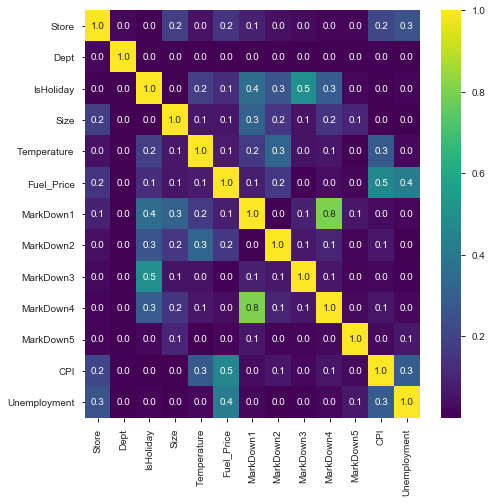

In [23]:
test_corr=pd.DataFrame(test.corr())
fig, ax = plt.subplots(figsize=(7.5,7.5))  
sns.heatmap(test_corr.abs(),cmap='viridis', fmt=".1f",annot=True , ax=ax)

## 3 Data Exploratory Analysis

### 3.1 Plots

#### 3.1.1 Stores

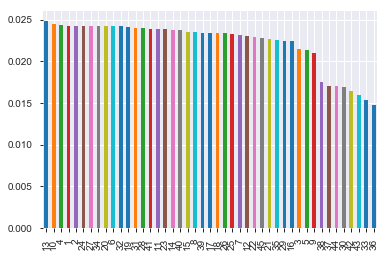

In [24]:
train['Store'].value_counts(normalize=True).plot(kind = 'bar',fig=(4,5))

- There are more number of Store 13 and very less number of Store 36

#### 3.1.2 Weekly Sales

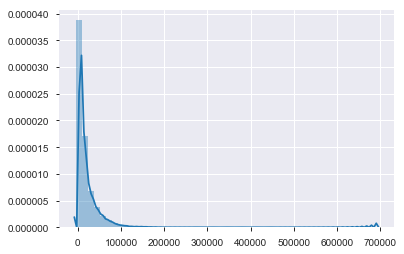

In [26]:
sns.distplot(train[['Weekly_Sales']])

#### 3.1.3 CPI

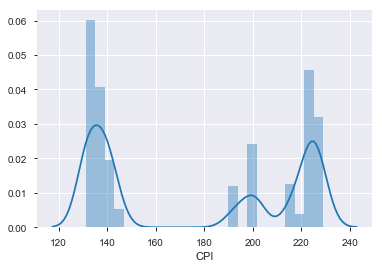

In [35]:
sns.distplot(test[test['CPI'].notna()]['CPI'])

#### 3.1.4 Unemployment

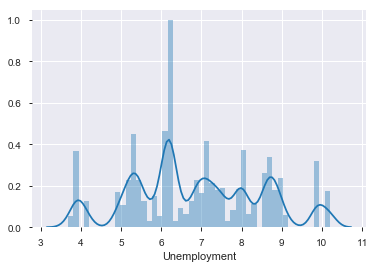

In [33]:
sns.distplot(test[test['Unemployment'].notna()]['Unemployment'])

#### 3.1.5 Store Size vs Sales

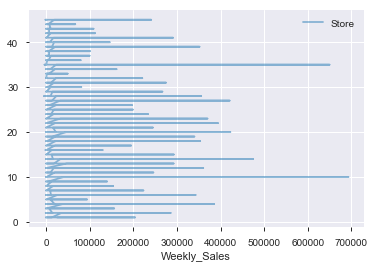

In [27]:
train.plot(kind='line', x='Weekly_Sales', y='Store', alpha=0.5)

- Store 10 has the highest Sales

#### 3.1.6 Sales vs Type

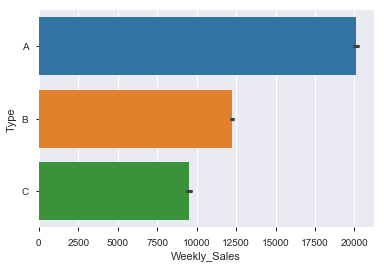

In [28]:
sns.barplot(x=train["Weekly_Sales"],y=train["Type"])

- 'Type C' stores have fewer sales and 'Type A' stores have more sales in general.

#### 3.1.7 Sales vs Deptartment

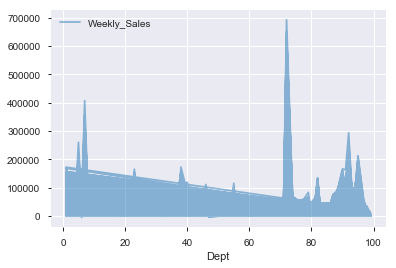

In [29]:
train.plot(kind='line', x='Dept', y='Weekly_Sales', alpha=1.5,fig=(4,5))

- Deptartment with the highest sales lies between Dept 60 and 80

### 3.2 Missing Value Treatment

#### 3.2.1 Counting Null Values

In [30]:
print train.isnull().sum()
print "*"*30
print test.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64
******************************
Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64


#### 3.2.2 Imputing with mean

In [36]:
test['CPI']=test.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()))
test['Unemployment']=test.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.mean()))

#### 3.2.3    Imputing with Zero
    Imputing Markdowns with Zero implies No Markdown

In [37]:
train=train.fillna(0)
test=test.fillna(0)

In [38]:
print train.isnull().sum()
print "*"*30
print test.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64
******************************
Store           0
Dept            0
Date            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


### 3.3 Outlier Treatment

In [39]:
train.Weekly_Sales=np.where(train.Weekly_Sales>100000, 100000,train.Weekly_Sales)

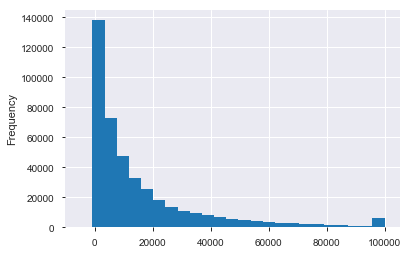

In [40]:
train.Weekly_Sales.plot.hist(bins=25)

_______________

## 4 Feature Selection

- Select the appropriate features to train our regressor.
- Create new features based on existing features.
- Convert categorical features into numeric form.

### 4.1  Datetime variables

#### 4.1.1 Convert Datatype

In [41]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

#### 4.1.2 Create New Features

In [42]:
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month 
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day 

test['Date_dayofweek'] =test['Date'].dt.dayofweek
test['Date_month'] =test['Date'].dt.month 
test['Date_year'] =test['Date'].dt.year
test['Date_day'] =test['Date'].dt.day 

### 4.2 Object to Interger 

In [46]:
train_test_data = [train, test]

#### 4.2.1 Type

In [47]:
print train.Type.value_counts()
print "*"*30
print test.Type.value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64
******************************
A    58713
B    44500
C    11851
Name: Type, dtype: int64


    Converting Categorical Variable 'Type' into Numerical Variable 
    For A=1 , B=2, C=3

In [48]:
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_test_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

#### 4.2.2 IsHoliday

In [49]:
print train.IsHoliday.value_counts()
print "*"*30
print test.IsHoliday.value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64
******************************
False    106136
True       8928
Name: IsHoliday, dtype: int64


    Converting Categorical Variable 'IsHoliday' into Numerical Variable 

In [50]:
type_mapping = {False: 0, True: 1}
for dataset in train_test_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

### 4.3 Extra Holidays

#### 4.3.1 Extra Holidays Variables
    Creating Extra Holiday Variable.
    If that week comes under extra holiday then 1(=Yes) else 2(=No)

In [51]:
train['Super_Bowl'] = np.where((train['Date']==datetime(2010, 2, 12)) | (train['Date']==datetime(2011, 2, 11)) | (train['Date']==datetime(2012, 2, 10)) | (train['Date']==datetime(2013, 2, 8)),1,0)
train['Labour_Day'] = np.where((train['Date']==datetime(2010, 9, 10)) | (train['Date']==datetime(2011, 9, 9)) | (train['Date']==datetime(2012, 9, 7)) | (train['Date']==datetime(2013, 9, 6)),1,0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)

test['Super_Bowl'] = np.where((test['Date']==datetime(2010, 2, 12)) | (test['Date']==datetime(2011, 2, 11)) | (test['Date']==datetime(2012, 2, 10)) | (test['Date']==datetime(2013, 2, 8)),1,0)
test['Labour_Day'] = np.where((test['Date']==datetime(2010, 9, 10)) | (test['Date']==datetime(2011, 9, 9)) | (test['Date']==datetime(2012, 9, 7)) | (test['Date']==datetime(2013, 9, 6)),1,0)
test['Thanksgiving'] = np.where((test['Date']==datetime(2010, 11, 26)) | (test['Date']==datetime(2011, 11, 25)) | (test['Date']==datetime(2012, 11, 23)) | (test['Date']==datetime(2013, 11, 29)),1,0)
test['Christmas'] = np.where((test['Date']==datetime(2010, 12, 31)) | (test['Date']==datetime(2011, 12, 30)) | (test['Date']==datetime(2012, 12, 28)) | (test['Date']==datetime(2013, 12, 27)),1,0)


In [53]:
train.Christmas.value_counts()
train.Super_Bowl.value_counts()
train.Thanksgiving.value_counts()
train.Labour_Day.value_counts()

0    415624
1      5946
Name: Christmas, dtype: int64

0    412675
1      8895
Name: Super_Bowl, dtype: int64

0    415611
1      5959
Name: Thanksgiving, dtype: int64

0    412709
1      8861
Name: Labour_Day, dtype: int64

In [54]:
test.Christmas.value_counts()
test.Super_Bowl.value_counts()
test.Thanksgiving.value_counts()
test.Labour_Day.value_counts()

0    112076
1      2988
Name: Christmas, dtype: int64

0    112100
1      2964
Name: Super_Bowl, dtype: int64

0    112088
1      2976
Name: Thanksgiving, dtype: int64

0    115064
Name: Labour_Day, dtype: int64

#### 4.3.2 Updating IsHoliday
    Altering the isHoliday value depending on these new holidays


In [52]:
train['IsHoliday']=train['IsHoliday']|train['Super_Bowl']|train['Labour_Day']|train['Thanksgiving']|train['Christmas']
test['IsHoliday']=test['IsHoliday']|test['Super_Bowl']|test['Labour_Day']|test['Thanksgiving']|test['Christmas']

#### 4.3.3 Dropping Extra Holiday variables
    Imputed IsHoliday according to Extra holidays.
    Extra holiday variables have redundant data

In [55]:
dp=['Super_Bowl','Labour_Day','Thanksgiving','Christmas']
train.drop(dp,axis=1,inplace=True)
test.drop(dp,axis=1,inplace=True)

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
Store             421570 non-null int64
Dept              421570 non-null int64
Date              421570 non-null datetime64[ns]
Weekly_Sales      421570 non-null float64
IsHoliday         421570 non-null int64
Type              421570 non-null int64
Size              421570 non-null int64
Temperature       421570 non-null float64
Fuel_Price        421570 non-null float64
MarkDown1         421570 non-null float64
MarkDown2         421570 non-null float64
MarkDown3         421570 non-null float64
MarkDown4         421570 non-null float64
MarkDown5         421570 non-null float64
CPI               421570 non-null float64
Unemployment      421570 non-null float64
Date_dayofweek    421570 non-null int64
Date_month        421570 non-null int64
Date_year         421570 non-null int64
Date_day          421570 non-null int64
dtypes: datetime64[ns](1), float64(10), int64(9)
memory usag

## 5 Train and Test Data

In [57]:
#Converting all float var int integer..

for var in train:
    if train[var].dtypes == float:
        train[var]=train[var].astype(int)
        
for var in test:
    if test[var].dtypes == float:
        test[var]=test[var].astype(int)

### 5.1 KFold Cross Validation
    - Grouping data by Store and department
    - Creating variable fold by Cross validation with split count 4
    - Splitting data in fold to train and test

In [59]:
kf = KFold(n_splits=4)
splited = []
dataset = pd.DataFrame(train.drop(columns=['Date']))
for name, group in dataset.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    if group.shape[0] <= 4:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)

In [60]:
splited.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Date_dayofweek,Date_month,Date_year,Date_day,fold
0,1,1,24924,0,1,151315,42,2,0,0,0,0,0,211,8,4,2,2010,5,0.0
1,1,1,46039,1,1,151315,38,2,0,0,0,0,0,211,8,4,2,2010,12,0.0


## 6 Models

### 6.1 Model Building
- KNeighborsRegressor
    - The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set
<br><br>    
- ExtraTreesRegressor
    - This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
<br><br>       
- RandomForestRegressor
    - ExtraTrees classifier always tests random splits over fraction of features (in contrast to RandomForest, which tests all possible splits over fraction of features)

    - A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).
<br><br>   
- MLPRegressor
    - This model optimizes the squared-loss using LBFGS or stochastic gradient descent.

In [61]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', n_jobs=1,verbose=100)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators=100,max_features='log2' ,verbose=100)
    return clf

def nn():
    clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu' ,verbose=100)
    return clf

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))


def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(model_,train_x, train_y, test_x):
    m = model_.fit(train_x, train_y)
    return predict_(m, test_x), m

def calculate_error(test_y, predicted):
    return mean_absolute_error(test_y, predicted)



In [62]:
Model = []
Score = []

for fold,reg in zip(range(5),[knn(),extraTreesRegressor(),randomForestRegressor(),nn()]):
    dataset_train = splited.loc[splited['fold'] != fold]
    dataset_test = splited.loc[splited['fold'] == fold]
    train_y = dataset_train['Weekly_Sales']
    train_x = dataset_train.drop(columns=['Weekly_Sales', 'fold'])
    test_y = dataset_test['Weekly_Sales']
    test_x = dataset_test.drop(columns=['Weekly_Sales', 'fold'])
    print(dataset_train.shape, dataset_test.shape)
    predicted, model = train_and_predict(reg,train_x, train_y, test_x)
    error = calculate_error(test_y, predicted)
    name = str(reg).split('(')[0]
    Model.append(name)
    Score.append(error)

models = pd.DataFrame({
    'Model': Model,
    
    'Score': Score
    })

((315114, 20), (106230, 20))
((315279, 20), (106065, 20))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   14.0s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   16.4s remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   18.7s remaining:    0.0s
building tree 9 of 100
[Parallel(n_jo

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  3.0min remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.1min remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  3.1min remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:  3.1min remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:  3.2min remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  3.2min remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  3.2min remaining:    0.0s
building tree 86 of 100
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:  3.3min remaining:    0.0s
building tree 87 of 100
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  3.3min remaining:    0.0s
building tree 88 of 100
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:  3.4min rem

[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  89 out of  8

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  1.0min remaining:    0.0s
building tree 62 of 100
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:  1.1min remaining:    0.0s
building tree 63 of 100
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:  1.1min remaining:    0.0s
building tree 64 of 100
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  1.1min remaining:    0.0s
building tree 65 of 100
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  1.1min remaining:    0.0s
building tree 66 of 100
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:  1.1min remaining:    0.0s
building tree 67 of 100
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:  1.1min remaining:    0.0s
building tree 68 of 100
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:  1.2min remaining:    0.0s
building tree 69 of 100
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:  1.2min remaining:    0.0s
building tree 70 of 100
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.2min rem

[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  6

Iteration 108, loss = 167011992.54581678
Iteration 109, loss = 167096387.45328969
Iteration 110, loss = 166865159.93873385
Iteration 111, loss = 166755278.77898023
Iteration 112, loss = 166442432.54795051
Iteration 113, loss = 166596099.87608358
Iteration 114, loss = 166691660.97577095
Iteration 115, loss = 166418238.22842473
Iteration 116, loss = 166584107.77772388
Iteration 117, loss = 166589030.27898970
Iteration 118, loss = 166043464.75472781
Iteration 119, loss = 166119685.42990690
Iteration 120, loss = 166407366.01985514
Iteration 121, loss = 165970543.49072540
Iteration 122, loss = 166066738.53570279
Iteration 123, loss = 165998196.93534935
Iteration 124, loss = 165834511.41583726
Iteration 125, loss = 165933676.99968985
Iteration 126, loss = 165753781.36573523
Iteration 127, loss = 165875862.64551097
Iteration 128, loss = 165893614.96796104
Iteration 129, loss = 165783085.41978949
Iteration 130, loss = 165749311.36543009
Iteration 131, loss = 165443677.82114810
Iteration 132, l

### 6.2 Model Comparison
    - Comparing Models based on score which is MAE (Mean Absolute Error)

In [63]:
models.sort_values(by='Score')

,Model,Score
1,ExtraTreesRegressor,1906.358945
2,RandomForestRegressor,6668.725683
0,KNeighborsRegressor,9031.918297
3,MLPRegressor,11809.967960


**Extra Trees Regressor** _has least MAE. It is the final model selected_

### 6.3 Predicting Weekly Sales for Test Data

In [64]:
# Prediction value using Random Forest model..
submission = pd.DataFrame({
        "Store_Dept_Date": test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),
        "Weekly_Sales": ExtraTreesRegressor(n_estimators=100,max_features='auto', n_jobs=1,verbose=100).fit(train_x, train_y).predict(test.drop(columns=['Date']))
    })

submission.to_csv('weekly_sales predicted.csv', index=False)
submission.to_excel(writer,'Weekly_sales Pred',index=False)
writer.save()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.8s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.0s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.2s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   15.3s remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   17.5s remaining:    0.0s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   19.7s remaining: 

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  2.7min remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.7min remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  2.7min remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:  2.7min remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:  2.7min remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  2.8min remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  2.8min remaining:    0.0s
building tree 86 of 100
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:  2.8min remaining:    0.0s
building tree 87 of 100
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  2.9min remaining:    0.0s
building tree 88 of 100
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:  2.9min rem

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  8

In [65]:
submission.head()

,Store_Dept_Date,Weekly_Sales
0,1_1_2012-11-02,29314.72
1,1_2_2012-11-02,45407.23
2,1_3_2012-11-02,9271.19
3,1_4_2012-11-02,35208.30
4,1_5_2012-11-02,28071.68
